# Probabilistic ranking
In this part of the assignment you will analyze a data set consisting of tennis singles matches in the WTA 2013 Tour. (The data is adapted from https://github.com/JeffSackmann/tennis_wta, accessed on 2019-10-23.) The file `players.csv` contains a list of the top 260 players (according to their WTA ranking in June 2013) with unique player IDs, WTA rank and ranking points, name, and country. The list is sorted according to WTA rank. The file `matches2013.csv` contains a list of all matches played between these 260 top players, during the 2013 tour, with one match per row. The first column contains the ID of the winner of that match, and the second column contains the ID of the loser. **Note that, with this convention, the variable $y_k$ used in the lectures to define the model is one for all games: $y_k = 1$, $k=1, \,  \dots, \, N$.**


The task is to compute posterior player skills, using the (simplified version of the) TrueSkill model that we discussed in the lectures. We set the skill prior variance to $\sigma_0^2 = 0.5$.

First we import some useful packages and load the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm

players_df = pd.read_csv("players.csv")
matches_df = pd.read_csv("matches2013.csv")

# Get arrays with the ID of winner and loser, respectively, for each match.
# Subtract 1 to correspond with Python indexing (ID starts at 1 in players.csv)
I_k = matches_df["winner_id"].to_numpy() - 1
J_k = matches_df["loser_id"].to_numpy() - 1

N = len(I_k) # Number of matches
M = players_df.shape[0] # Number of players

sigma2_0 = 0.5 # Skill prior variance


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
players_df

,player_id,rank,ranking_points,name,country_code
0,1,1,11620,Serena Williams,USA
1,2,2,10015,Maria Sharapova,RUS
2,3,3,9005,Victoria Azarenka,BLR
3,4,4,6125,Agnieszka Radwanska,POL
4,5,5,5835,Sara Errani,ITA
...,...,...,...,...,...
255,256,256,210,Melanie Klaffner,AUT
256,257,257,206,Kristina Kucova,SVK
257,258,258,205,Adriana Perez,VEN
258,259,259,204,Diana Marcinkevica,LAT


In [3]:
N, M

(2459, 260)

In [4]:
I_k, len(I_k)

(array([ 33,  39, 111, ..., 186, 250, 250]), 2459)

In [5]:
J_k

array([ 28,  32,   9, ..., 258, 157, 258])

# Expectation propagation
The first task is to implement an Expectation Propagation (EP) algorithm to solve the problem outlined above.

**Q1:** Let $\mathbf{y}$ denote the observed data (i.e., a vector with the outcomes of the 260 played matches). Write down pseudo-code for the EP algorithm for approximating the posterior marginals over skill and performance variables,
$$
p(w_i \mid \mathbf{y}), \quad i=1,\,\dots,\,M, \\
p(t_k \mid \mathbf{y}), \quad k=1,\,\dots,\,N.
$$
Write out explicit expressions for all the messages involved. Intractable messages should be approximated by Gaussian densities. Follow the steps outlined in the lecture (see specifically slides 30-36), starting with computing the skill marginals, followed by a downward pass and then a backward pass of messages.
		
_Note: You may use both the standard form and the information form of the Gaussian messages: $N(\mu, \sigma^2) = N_I(\nu,\lambda)$. That is, when writing out the expression for the hyper-parameter update for each message, you can use the most convenient parameterization for that particular update, as long as it is clear from the notation which hyper-parameters that belong together. (For instance, write $\mu_{f\rightarrow x}$ and $\nu_{f\rightarrow x}$ to refer to the mean and natural mean of the message $m_{f\rightarrow x}(x)$.)_

#### step 0: Initialize game-to-skill messages

$$
     m_{g_i\rightarrow w_i}(w_i) = N_I(0 ,0)
$$

#### step 1: Update skill marginals
given that:

$$
     N_I(w|\nu_a, \lambda_a)N_I(w|\nu_b, \lambda_b) = N_I(w|\nu_a + \nu_b, \lambda_a+\lambda_b) 
$$

assuming:

$$
     f_i(w_i) = N_I(w_i|0, \frac{1}{0.5} )
$$

gives:

$$
     q(w_i) \propto f_i(w_i) \cdot \prod_{\forall k \exists g_k \rightarrow w_i} m_{g_k\rightarrow w_i}(w_i) = N_I(w_i | 0+\sum_{\forall k \exists g_k \rightarrow w_i} \nu_{g_k\rightarrow w_i}, \frac{1}{0.5}+\sum_{\forall k \exists g_k \rightarrow w_i} \lambda_{g_k\rightarrow w_i})
$$

#### Step 2: Compute skill-to-game messages
given that:

$$
     \frac{N_I(w|\nu_a, \lambda_a)}{N_I(w|\nu_b, \lambda_b)} = N_I(w|\nu_a - \nu_b, \lambda_a-\lambda_b) 
$$

assuming:

$$
     q(w_i) = N_I(w_i|\nu_i, \lambda_i )
$$

gives:

$$m_{w_i\rightarrow g_k}(w_i) = \frac{q(w_i)}{m_{g_k\rightarrow w_i}(w_i)} =  N_I(w_i|\nu_i - \nu_{g_k\rightarrow w_i}, \lambda_i - \lambda_{g_k\rightarrow w_i} )$$

#### Step 3: Compute game-to-performance messages
given that:

$$
     \int N(x|y , γ_2)N(y | \mu, σ^2)dy = N(x |\mu, γ_2 + σ^2) 
$$

assuming:

$$
     g_k(t_k, w_{I_k}, w_{J_k}) = p(t_k | w_{I_k}, w_{J_k}) = N(t_k | w_{I_k} - w_{J_k} , 1)
$$

$$
     m_{w_{I_k}\rightarrow g_k} = N(w_{I_k}|\mu_{I_k}, \sigma_{I_k}^2 )
$$

$$   
     m_{w_{J_k}\rightarrow g_k} = N(w_{J_k}|\mu_{J_k}, \sigma_{J_k}^2 )
$$

gives:

$$
     m_{g_k\rightarrow t_k}(t_k) = \int\int g_k(t_k, w_{I_k}, w_{J_k}) \times m_{w_{I_k}\rightarrow g_k}(w_{I_k}) m_{w_{J_k}\rightarrow g_k}(w_{J_k}) d w_{I_k} w_{J_k} 
     
$$

$$
     = \int\int  N(t_k | w_{I_k} - w_{J_k} , 1)N(w_{I_k}|\mu_{I_k}, \sigma_{I_k}^2 ) N(w_{J_k}|\mu_{J_k}, \sigma_{J_k}^2 )d w_{I_k} w_{J_k}
$$

$$
     = \int  N(t_k | w_{I_k} - \mu_{J_k}, 1+\sigma_{J_k}^2)N(w_{I_k}|\mu_{I_k}, \sigma_{I_k}^2 )d w_{I_k}
$$

$$
     = N(t_k | \mu_{I_k} - \mu_{J_k}, 1+\sigma_{J_k}^2+\sigma_{I_k}^2)
$$

#### Step 4: Update performance marginals
assuming:

$$h_k(t_k) = p(y_k | t_k ) = \delta_{sign(t_k )}(y_k ) = \mathbb{1}(y_k t_k > 0) $$

gives:

$$\pi(t_k) \propto h_k(t_k) m_{g_k\rightarrow t_k}(t_k) =  N(t_k| \mu_{\pi_k}, \sigma_{\pi_k})$$ 

and approximate using moment matching,

$$q(t_k) \approx \pi(t_k) =  N(t_k| \mu_{a_k}, \sigma_{a_k})$$


#### Step 5: Compute performance-to-game messages
given that:
$$
     \frac{N_I(w|\nu_a, \lambda_a)}{N_I(w|\nu_b, \lambda_b)} = N_I(w|\nu_a - \nu_b, \lambda_a-\lambda_b) 
$$

assuming:
$$
     q(t_k)  =  N_I(t_k| \nu_{a_k}, \lambda_{a_k})
$$

gives:
$$
     m_{t_k\rightarrow g_k}(t_k) = \frac{q(t_k)}{m_{g_k\rightarrow t_k}(t_k)} =  N_I(t_k|\nu_{a_k} - \nu_{g_k\rightarrow t_k}, \lambda_{a_k} - \lambda_{g_k\rightarrow t_k} )
$$


#### Step 6: Compute game-to-skill messages

given that:

$$
     \int N(x|y , γ_2)N(y | \mu, σ^2)dy = N(x |\mu, γ_2 + σ^2) 
$$

assuming:

$$
     g_k(t_k, w_{I_k}, w_{J_k}) = p(t_k | w_{I_k}, w_{J_k}) = N(t_k | w_{I_k} - w_{J_k} , 1)
$$

$$
     m_{t_k\rightarrow g_k} = N(t_k|\mu_{t_k}, \sigma_{t_k}^2 )
$$

$$   
     m_{w_{J_k}\rightarrow g_k} = N(w_{J_k}|\mu_{J_k}, \sigma_{J_k}^2 )
$$

gives:

$$
     m_{g_k\rightarrow w_{I_k}}(w_{I_k}) = \int\int g_k(t_k, w_{I_k}, w_{J_k}) \times m_{t_k\rightarrow g_k}(t_k) m_{w_{J_k}\rightarrow g_k}(w_{J_k}) d t_k w_{J_k} = 
$$

$$
     = \int\int  N(t_k | w_{I_k} - w_{J_k} , 1)N(t_k|\mu_{t_k}, \sigma_{t_k}^2 ) N(w_{J_k}|\mu_{J_k}, \sigma_{J_k}^2 )d t_k w_{J_k}
$$

$$
     = \int\int  N( w_{I_k} | t_k + w_{J_k} , 1) N(t_k|\mu_{t_k}, \sigma_{t_k}^2 ) N(w_{J_k}|\mu_{J_k}, \sigma_{J_k}^2 )d t_k w_{J_k}
$$

$$
= N(w_{I_k}| \mu_{t_k}+\mu_{J_k}, 1 + \sigma_{t_k}^2+\sigma_{J_k}^2 )
$$

#### step 7: 
check for convergence or go to step 1

**Q2:** In the lecture slides it is recommended to initialize the game-to-skill messages $m^{(0)}_{g_k\rightarrow w_i}(w_i) \equiv 1$ for $i \in I_k \cup J_k$.

1. What does this imply for the skill marginals (computed in Step 1) at the first iteration of the algorithm, i.e. what will $q^{(1)}(w_i)$ correspond to?
2. How can you implement $m^{(0)}_{g_k\rightarrow w_i}(w_i) \equiv 1$ in practice?

_Hint: What should the message parameters correspond to in order to get the desired skill marginals, as identified in Q2.1?_


This imply $q^{(1)}(w_i)$ equal to prior and no biased information initially added to each player. $m^{(0)}_{g_k\rightarrow w_i}(w_i) \equiv 1$ could be $1$ or a normal distribution with infinity variance. 

**Q3:** Implement the EP message passing algorithm for the WTA data to approximate the posterior marginal skills $q(w_i) \approx p(w_i \mid \mathbf{y})$, $i=1,\,\dots,\,M$ and the posterior performance marginals $q(t_k) \approx p(t_k \mid \mathbf{y})$, $k=1,\,\dots,\,N$ by completing the code below. Plot the (approximations of) the posterior means $\pm 1$ standard deviation vs player ID for the skills.
		
_Note: For simplicity you are not required to implement a stopping criterion for the convergence of the algorithm (unless you want to!). It is sufficient to run it for a fixed number of iterations, say, 50._
		
_Note: Use either the standard form or the information form parameterization of the Gaussian messages in the implementation, and transform between them when necessary._
		
_Note: We have implemented a method for computing the moments of a truncated normal distribution for you. See e.g., the Wikipedia page on the truncated normal distribution for the expressions for the moments, https://en.wikipedia.org/wiki/Truncated_normal_distribution_

In [6]:
# Two helper functions used in the code below

def switch_gaussian_parameterization(mu_or_nu, sigma2_or_lambda):
    # Converts between standard and information form of normal distribuion
    # Note that the "conversion formulas" are symmetric, so the same function
    # can be used both ways:
    #   mu = nu/lambda       nu = mu/sigma2
    #   sigma2 = 1/lambda    lambda = 1/sigma2
    assert (sigma2_or_lambda >= 0).all(), "Inf, or negative variance"
    assert (sigma2_or_lambda > 0).all(), "0"
    return mu_or_nu/sigma2_or_lambda, 1/sigma2_or_lambda

def get_truncated_params(mu, sigma2):
    # Compute mean and variance of Gaussian truncated to positive real line 
    # N(x|mu_trunc,sigma2_trunc) \approx 1{x>=0}*N(x|mu, sigma2) 
    sigma = np.sqrt(sigma2)
    Z = 1 - st.norm.cdf(0, loc=mu, scale=sigma)
    phi = st.norm.pdf(0, loc=mu, scale=sigma)
    mu_trunc = mu + phi * sigma / Z
    sigma2_trunc = sigma2 * (1 - (mu * phi / (sigma * Z)) - ((phi / Z) ** 2))
    return mu_trunc, sigma2_trunc

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.29it/s]


Posterior mean: 2.33, var: 0.21, points:   3625, id: 9 name: Caroline Wozniacki 
Posterior mean: 2.29, var: 0.19, points:   5135, id: 7 name: Angelique Kerber 
Posterior mean: 2.28, var: 0.20, points:   3645, id: 8 name: Samantha Stosur 
Posterior mean: 2.27, var: 0.22, points:   3036, id: 11 name: Maria Kirilenko 
Posterior mean: 2.26, var: 0.24, points:   1475, id: 36 name: Laura Robson 
Posterior mean: 2.26, var: 0.20, points:   2800, id: 13 name: Ana Ivanovic 
Posterior mean: 2.25, var: 0.26, points:   1028, id: 57 name: Madison Keys 
Posterior mean: 2.24, var: 0.23, points:   1136, id: 51 name: Magdalena Rybarikova 
Posterior mean: 2.24, var: 0.22, points:   1908, id: 20 name: Kirsten Flipkens 
Posterior mean: 2.24, var: 0.20, points:   2500, id: 17 name: Jelena Jankovic 
Posterior mean: 2.24, var: 0.18, points:   5175, id: 6 name: Petra Kvitova 
Posterior mean: 2.23, var: 0.23, points:   1500, id: 34 name: Mona Barthel 
Posterior mean: 2.23, var: 0.18, points:   2785, id: 14 name

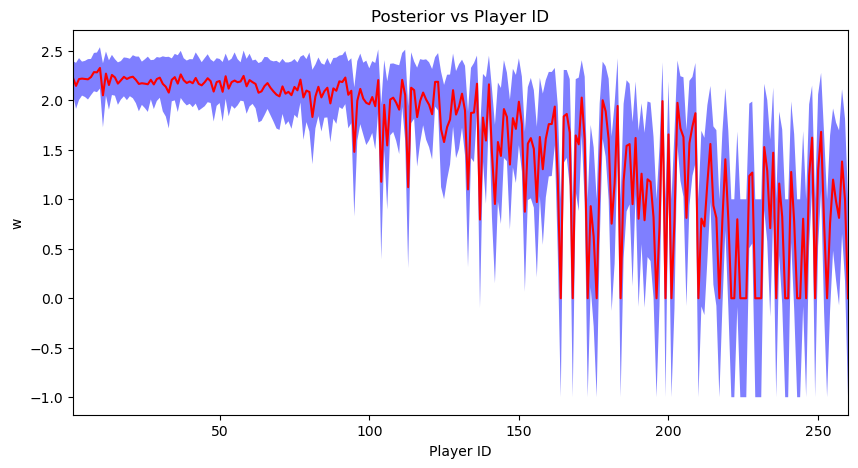

In [7]:
N_ITER_EP = 100

# Message Passing
# STEP 0: Initialize game to skill messages
#  - Each game sends a message to both players in that game. How many "g2w messages" do we have?
#  - The messages are Gaussian and we use the information form to represent these functions.
#  - How should we initialize the messages? See Q2 above.
#
# Natural means
m_g2w_nu = np.ones((N, 2)) 
# Precisions
m_g2w_lambda =  np.ones((N, 2))

PRIOR_LAMBDA = 2
GAME_VARIANCE = 1

for tau in tqdm(range(N_ITER_EP)):
    # STEP 1: Update skill marginals
    q_w_nu = np.zeros(M)
    q_w_lambda = np.zeros(M) + 1 # prior belief 
    for i, j, nu, lam in zip(I_k, J_k, m_g2w_nu, m_g2w_lambda):
        # One way to implement this is to loop over all games and update the parameters of the skill marginals game-by-game
        # (but you can of course implement this any way you want).
        #
        # i = first player in game k (winner according to our convention/sorting of data)
        # j = second player in game k
        # nu = natural mean of message sent from game k to the two participating players. Shape (2,) for winner/loser
        # lam = precision of message sent from game k to the two participating players. Shape (2,) for winner/loser
        nu_i, nu_j = nu
        lam_i, lam_j = lam
        q_w_nu[i] += nu_i
        q_w_lambda[i] += lam_i
        q_w_nu[j] += nu_j
        q_w_lambda[j] += lam_j



    # STEP 2: Skill to game messages
    m_w2g_nu = np.zeros((N, 2))
    m_w2g_lambda = np.zeros((N, 2))
    for g, (i, j, nu, lam) in enumerate(zip(I_k, J_k, m_g2w_nu, m_g2w_lambda)):
        nu_i, nu_j = nu
        lam_i, lam_j = lam
        m_w2g_nu[g, 0] = q_w_nu[i] - nu_i
        m_w2g_lambda[g, 0] = q_w_lambda[i] - lam_i
        m_w2g_nu[g, 1] = q_w_nu[j] - nu_j
        m_w2g_lambda[g, 1] = q_w_lambda[j] - lam_j
        

    # STEP 3: Game to performance messages
    # Switch to standard parameterization to more easily carry out the "convolution" to compute these messages
    m_w2g_mu, m_w2g_sigma2 = switch_gaussian_parameterization(m_w2g_nu, m_w2g_lambda)
    
    m_g2t_mu = np.zeros(N)
    m_g2t_sigma2 = np.zeros(N)
    for g, (i, j, mu, sigma) in enumerate(zip(I_k, J_k, m_w2g_mu, m_w2g_sigma2)):
        mu_i, mu_j = mu
        sigma2_i, sigma2_j = sigma
        m_g2t_mu[g] = mu_i - mu_j
        m_g2t_sigma2[g] = GAME_VARIANCE + sigma2_i + sigma2_j



    # STEP 4: Update performance marginals
    # Note that h_k(t_k) = 1{t_k >= 0} for all t_k due to our convention that the winner is the first player
    q_t_mu, q_t_sigma2 = get_truncated_params(m_g2t_mu, m_g2t_sigma2)
    
    # STEP 5: Performance to game messages
    # Switch to information form to more easily be able to "subtract information"
    q_t_nu, q_t_lambda = switch_gaussian_parameterization(q_t_mu, q_t_sigma2)
    m_g2t_nu, m_g2t_lambda = switch_gaussian_parameterization(m_g2t_mu, m_g2t_sigma2)

    m_t2g_nu = q_t_nu - m_g2t_nu 
    m_t2g_lambda = q_t_lambda - m_g2t_lambda

 
    # STEP 6: Game to skill messages
    # Switch to standard form to carry out convolution
    m_t2g_mu, m_t2g_sigma2 = switch_gaussian_parameterization(m_t2g_nu, m_t2g_lambda)

    m_g2w_mu = np.zeros((N, 2))
    m_g2w_sigma2 = np.zeros((N, 2))

    for g, (i, j) in enumerate(zip(I_k, J_k)):
        m_g2w_mu[g, 0] = q_t_mu[g] + m_t2g_mu[j]
        m_g2w_sigma2[g, 0] = GAME_VARIANCE + q_t_sigma2[g] + m_t2g_sigma2[j]
        m_g2w_mu[g, 1] = q_t_mu[g] + m_t2g_mu[i]
        m_g2w_sigma2[g, 1] = GAME_VARIANCE + q_t_sigma2[g] + m_t2g_sigma2[i]
    # Convert to information form for the next iteration
    m_g2w_nu, m_g2w_lambda = switch_gaussian_parameterization(m_g2w_mu, m_g2w_sigma2)


# Compute skill marginals on standard form    
q_w_mu, q_w_sigma2 = switch_gaussian_parameterization(q_w_nu, q_w_lambda)
q_w_sigma = np.sqrt(q_w_sigma2)

# Plot posterior
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
player_index = np.arange(M) +1
ax.fill_between(player_index, q_w_mu - q_w_sigma, q_w_mu + q_w_sigma,
        facecolor="blue", alpha=0.5)
ax.plot(player_index, q_w_mu, c="red")
ax.set_xlabel("Player ID")
ax.set_xlim(1, M)
ax.set_ylabel("w")
ax.set_title("Posterior vs Player ID")
for player_id in np.argsort(q_w_mu)[::-1][:20]:
    print(f"Posterior mean: {q_w_mu[player_id]:.2f}, var: {q_w_sigma[player_id]:.2f}, points: {players_df.iloc[player_id]['ranking_points']:6}, id: {player_id} name: {players_df.iloc[player_id]['name']} ")
    

**Q4:**  Using the EP approximation derive an expression for the posterior probability (under the TrueSkill model) that Serena Williams beats Maria Sharapova. More specifically, let $y_\text{new}$ be the outcome of a new match between these two players, where Williams is player 1 and Sharapove player 2. Then derive an expression for the probability,
$$
 \mathbb{P}(y_\text{new} = 1 | \mathbf{y}) = 1 - \int_{-\inf}^{0} N(y_\text{new} | \mu_{I} - \mu_{J}, 1+\sigma_{J}^2+\sigma_{I}^2)
$$
and show how this expression can be approximated (in a systematic way) using the output from the EP algorithm.

_Hint: The EP algorithm is based on the "mean field approximation" which you need to use when approximating the probability above._

**Q5:** Approximate the probability above using the output from your EP algorithm. What is the estimated probability?

In [8]:
# Compute win prob
from scipy.stats import norm
id_i = 0 # ID of Williams (in Python indexing)
id_j = 1 # ID of Sharapova (in Python indexing)
new_mu = q_w_mu[id_i] - q_w_mu[id_j]
new_sigma2 = q_w_sigma2[id_i] + q_w_sigma2[id_j] + GAME_VARIANCE
p_game = 1 - norm.cdf(0, loc=new_mu, scale=np.sqrt(new_sigma2))
name_i = players_df.iloc[id_i]["name"]
name_j = players_df.iloc[id_j]["name"]

print(f"P({name_i} beats {name_j}) = {p_game:.5}")

P(Serena Williams beats Maria Sharapova) = 0.53075


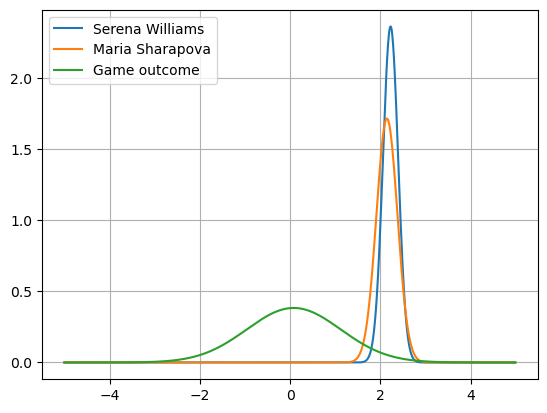

In [9]:
x_axis = np.arange(-5, 5, 0.01)
fig , ax = plt.subplots()
ax.plot(x_axis, norm.pdf(x_axis, q_w_mu[id_i], np.sqrt(q_w_sigma2[id_i])), label=name_i)
ax.plot(x_axis, norm.pdf(x_axis, q_w_mu[id_j], np.sqrt(q_w_sigma2[id_j])), label=name_j)
ax.plot(x_axis, norm.pdf(x_axis, new_mu, np.sqrt(new_sigma2)), label="Game outcome")
ax.legend()
ax.grid(True)


# Gibbs sampler
Next, we will implement a Gibbs sampler to solve the same problem and compare with the EP solution.

**Q6:** Write down pseudo-code for a Gibbs sampler using the following Gibbs sweep:
	$$
		\mathbf{w}' \sim p(\mathbf{w} \mid \mathbf{t}, \mathbf{y}), \\
		\mathbf{t}' \sim p(\mathbf{t} \mid \mathbf{w}', \mathbf{y}).
	$$
	Write out explicit expressions for the full conditionals. Which part(s) of the full conditionals can be precomputed outside the Gibbs loop?

$$
p(\mathbf{w} \mid \mathbf{t}, \mathbf{y}) = \prod_{i=1}^M \mathcal{N}_I(w_i | 0, \lambda) \prod_{k=1}^N \mathcal{N}_I(t_k|w_{Ik} - w_{Jk},1 )\\
=\prod_{i=1}^M \mathcal{N}(w_i | 0, \sigma^2) \prod_{k=1}^N \mathcal{N}([w_{Ik},w_{Jk}]| [\frac{t_k}{2}, -\frac{t_k}{2}], \begin{bmatrix}
1 & -1\\
-1 & 1
\end{bmatrix} )\\
=\prod_{i=1}^M \mathcal{N}_I(w_i | 0, \lambda) \prod_{k=1}^N \mathcal{N}_I([w_{Ik},w_{Jk}]| [t_k, -t_k], \begin{bmatrix}
1 & -1\\
-1 & 1
\end{bmatrix} ),~~~~~~~~~~~\lambda = \frac{1}{\sigma^2}
$$



**Q7:** Based on the expressions that you have derived above, implement a Gibbs sampler on the WTA data to approximate the posterior distribution $p(\mathbf{w},\mathbf{t}\mid\mathbf{y})$ by completing the code below. Then answer the following questions:

1. What is an appropriate number of iterations to run the sampler for? What does it mean for the sampler to "converge", i.e., what is the expected behavior in the long run?
1. By visual inspection of the Gibbs iterations, what is an appropriate length of the _burn-in_ period?
1. Plot the (approximations of) the posterior means $\pm 1$ standard deviation for the skills vs player ID. Try to interpret the result!

_Hint: Simulating from a truncated Gaussian distribution can be done using rejection sampling. Simply simulate from the non-truncated Gaussian, reject samples that fall outside the truncation interval, and keep simulating until you get a sample that falls in the truncation interval._

In [45]:
N_ITER_GIBBS = 1500 # Number of Gibbs iterations

# Gibbs Sampler
np.random.seed(123)

w_trace = []
t_trace = []

# Initialize t
t = np.zeros(N)


for i in tqdm(range(N_ITER_GIBBS)):
    # Sample w ~ p(w | t, y)    
    
    Sigma_inv = np.eye(M) / sigma2_0
    w_nu = np.zeros(M)
    
    for k in range(N):
        Sigma_inv[I_k[k],I_k[k]] += 1
        Sigma_inv[J_k[k],J_k[k]] += 1
        Sigma_inv[J_k[k],I_k[k]] -= 1
        Sigma_inv[I_k[k],J_k[k]] -= 1
        w_nu[I_k[k]] += t[I_k[k]] 
        w_nu[J_k[k]] -= t[J_k[k]]
    
    # matrix cook book 8.1.8 http://compbio.fmph.uniba.sk/vyuka/ml/old/2008/handouts/matrix-cookbook.pdf 
    Sigma = np.linalg.inv(Sigma_inv)
    w_mean =  Sigma @ w_nu
    w = np.random.multivariate_normal(w_mean, Sigma)
    
    # Sample t ~ p(t | w, y) using rejection sampling
    # (N,) array with mean of _untruncated_ distribution over variables t_k, k=1,...,N
    t_mean = w[I_k] - w[J_k]
    t = np.zeros(N)
    accept_mask = np.zeros(N).astype(bool) # All false
    num_remaining = np.sum(~accept_mask)
    while num_remaining > 0:        
        # Sample from untruncated Gaussian, N(t_mean, 1), for the remaining matches
        t[~accept_mask] = (np.random.randn(num_remaining) + t_mean[~accept_mask]) 
        accept_mask = (t >= 0)
        num_remaining = np.sum(~accept_mask)
    w_trace.append(w)
    t_trace.append(t)

100%|███████████████████████████████████████| 1500/1500 [00:36<00:00, 40.97it/s]


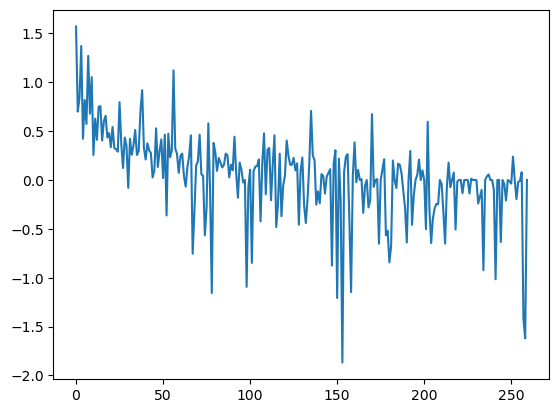

In [46]:
plt.plot(w_mean)

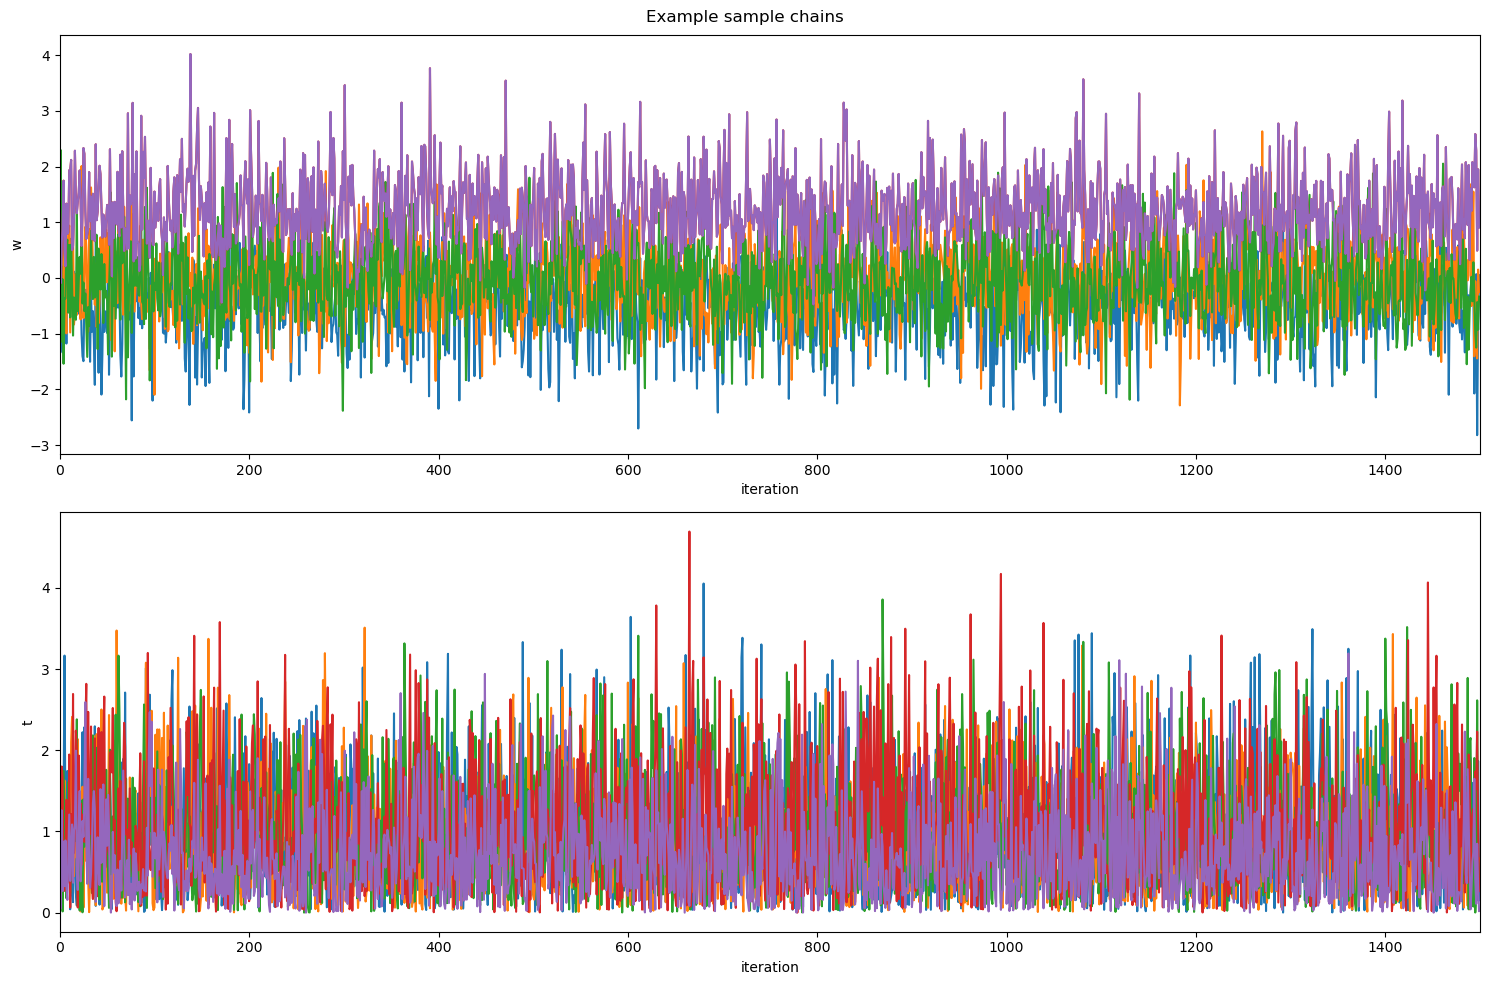

In [47]:
# Plot the traces
n_plot = 5 # We plot n_plot randomly selected players and matches, respectively
plot_w_i = np.random.randint(0,M,size=n_plot)
plot_t_i = np.random.randint(0,N,size=n_plot)

w_trace = np.array(w_trace)
t_trace = np.array(t_trace)
plot_w_chains = w_trace[:,plot_w_i]
plot_t_chains = t_trace[:,plot_t_i]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
for ax_i, chains, name in zip(ax, (plot_w_chains, plot_t_chains), ("w", "t")):
    ax_i.plot(chains)
    ax_i.set_ylabel(name)
    ax_i.set_xlabel("iteration")
    ax_i.set_xlim(0, N_ITER_GIBBS)

fig.suptitle("Example sample chains")
fig.tight_layout()


In [ ]:
burn_in = ... # Set the burn-in based on the traces above

# Compute posterior mean and standard deviation for player skills
w_post_mean = ...
w_post_std = ...

# Plot the posterior player skills vs ID
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
player_index = np.arange(M) +1
ax.fill_between(player_index, w_post_mean - w_post_std, w_post_mean + w_post_std, facecolor="blue", alpha=0.5)
ax.plot(player_index, w_post_mean, c="red")
ax.set_xlabel("Player ID")
ax.set_xlim(1, M)
ax.set_ylabel("w")
ax.set_title("Posterior vs Player ID")
fig.tight_layout()

**Q8:** Using the Gibbs approximation derive an expression for the posterior probability, under the TrueSkill model, that Serena Williams beats Maria Sharapova. More specifically, let $y_\text{new}$ be the outcome of a new match between these two players, where Williams is player 1 and Sharapove player 2. Then derive an expression for the probability,
$$
 \mathbb{P}(y_\text{new} = 1 | \mathbf{y}) = \dots
$$
and show how this expression can be approximated (in a systematic way) using the output from the Gibbs sampler.

_Hint:_ The Gibbs sampler approximates the _joint posterior_ and you should leverage this property when approximating the probability above.

**Q9:** Approximate the probability above using the output from your Gibbs sampler. What is the estimated probability?

In [ ]:
id_i = 0 # ID of Williams (in Python indexing)
id_j = 1 # ID of Sharapova (in Python indexing)
new_mu = q_w_mu[id_i] - q_w_mu[id_j]
new_sigma2 = q_w_sigma2[id_i] + q_w_sigma2[id_j] + GAME_VARIANCE
p_game = 1 - norm.cdf(0, loc=new_mu, scale=np.sqrt(new_sigma2))
name_i = players_df.iloc[id_i]["name"]
name_j = players_df.iloc[id_j]["name"]

print(f"P({name_i} beats {name_j}) = {p_game:.5}")

In [ ]:
x_axis = np.arange(-5, 5, 0.01)
fig , ax = plt.subplots()
ax.plot(x_axis, norm.pdf(x_axis, q_w_mu[id_i], np.sqrt(q_w_sigma2[id_i])), label=name_i)
ax.plot(x_axis, norm.pdf(x_axis, q_w_mu[id_j], np.sqrt(q_w_sigma2[id_j])), label=name_j)
ax.plot(x_axis, norm.pdf(x_axis, new_mu, np.sqrt(new_sigma2)), label="Game outcome")
ax.legend()
ax.grid(True)